In [19]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
# import cupy as np
import tensorflow as tf
from tensorflow import keras
from ideal_gas import *
from scipy.interpolate import interp1d
import pickle
# import tensorflow.experimental.numpy as np
print("Num GPUs Available: {}".format(len(tf.config.experimental.list_physical_devices("GPU"))))
print(tf.test.is_built_with_cuda())
print(tf.version.VERSION)
# gpus = tf.config.list_physical_devices("GPU")
# if gpus:
#     for gpu in gpus:
#         print("Found a GPU with the name: {}".format(gpu))
# else:
#     print("Failed to detect a GPU.")

Num GPUs Available: 1
True
2.10.1


In [2]:
def O(N, n):
    return np.math.factorial(N)/(np.math.factorial(N-n) * np.math.factorial(n))

def lorentzian(x):
    return 1/(x**2+1)

In [3]:
# # Create the simulation
# max_frames = 600
# max_trials = 1000

# sims = []
# for num in range(TRIALS):
#     particles = []
#     for _ in range(N_display-1):
#         particles.append(Particle( 
#                                RADIUS,
#                                (random.uniform(RADIUS, BOX_WIDTH-RADIUS), random.uniform(RADIUS, BOX_HEIGHT-RADIUS)),
#                                random.uniform(0, 2*np.pi),
#                                0,
#                                m_helium,
#                                (0, 0, 255)
#                             )
#                       )

#     particles.append(Particle( 
#                    RADIUS,
#                    (random.uniform(RADIUS, BOX_WIDTH-RADIUS), random.uniform(RADIUS, BOX_HEIGHT-RADIUS)),
#                    random.uniform(0, 2*np.pi),
#                    20,
#                    m_helium,
#                    (255, 255, 0)
#                 )
#           )

#     b = Map(particles, debug=False, maxwell_demon=False, non_ideal=True, display_speeds=False, sim_num=num, save_fig=False, animation=False)
#     b.run()
#     sims.append([b.result, b.speeds])

In [4]:
# Write sims to the pickle file
# DO THIS ONLY ONCE!!!
# with open("data.p", "wb") as f:
#     pickle.dump(sims, f)

C:\Users\joebs\AppData\Local\Temp\ipykernel_26724\1088137686.py:2: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return np.math.factorial(N)/(np.math.factorial(N-n) * np.math.factorial(n))
C:\Users\joebs\AppData\Local\Temp\ipykernel_26724\2385462616.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, x, y) # The Gaussian Function is NORMALIZED


[30.          3.88648165  1.        ]


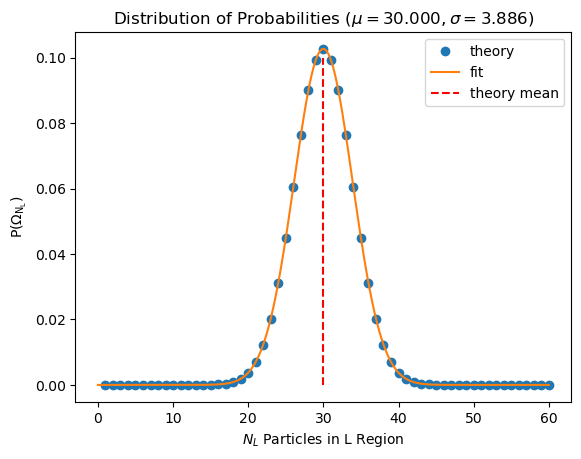

In [8]:
def gaussian(x, mean, standard_deviation, amplitude):
    return (1/standard_deviation/(np.sqrt(2*np.pi))) * np.exp(-(x-mean)**2 / (2*standard_deviation**2)) 

start = 1
N = 60
O_total = np.sum(np.array([O(N, n) for n in range(1, N+1)]))

x = [n for n in range(1, N+1)]
y = [O(N, n)/O_total for n in range(1, N+1)]

popt, _ = curve_fit(gaussian, x, y) # The Gaussian Function is NORMALIZED
print(popt)
x_fit = np.linspace(0, N, 10000)
y_fit_theory = gaussian(x_fit, *popt)
f_theory = interp1d(x_fit, y_fit_theory)

plt.figure()
plt.title("Distribution of Probabilities ($\mu={:.3f}, \sigma={:.3f})$".format(popt[0], popt[1]))
plt.xlabel("$N_L$ Particles in L Region")
plt.ylabel("$\mathrm{P}(\Omega_{\mathrm{N_L}})$")
plt.plot(x, y,"o", label="theory")
plt.plot(x_fit, y_fit_theory, "-", label="fit")
plt.vlines(popt[0], 0, 0.1, linestyle="--", color="r", label="theory mean")
plt.legend()
plt.savefig("probability_theory.png")
plt.show()

In [18]:
def run(N, trials, maximum_frames):
    """
    Run the simulations
    """
    sims = []
    for num in range(trials):
        if num%10==0:
            with open("data4.p", "wb") as f:
                pickle.dump(sims, f)
            print("trial {}/{} now saved!".format(num, trials))
        particles = []
        for _ in range(N-1):
            particles.append(Particle( 
                                   RADIUS,
                                   (random.uniform(RADIUS, BOX_WIDTH-RADIUS), random.uniform(RADIUS, BOX_HEIGHT-RADIUS)),
                                   random.uniform(0, 2*np.pi),
                                   0,
                                   m_helium,
                                   (0, 0, 255)
                                )
                          )
    
        particles.append(Particle( 
                       RADIUS,
                       (random.uniform(RADIUS, BOX_WIDTH-RADIUS), random.uniform(RADIUS, BOX_HEIGHT-RADIUS)),
                       random.uniform(0, 2*np.pi),
                       100,
                       m_helium,
                       (255, 255, 0)
                    )
              )
    
        b = Map(particles, 
                debug=False, 
                maxwell_demon=False, 
                non_ideal=True, 
                display_speeds=False, 
                sim_num=num, 
                save_fig=False, 
                animation=False,
                max_frames=600,
                boundary=BOX_WIDTH/2)
        b.run()
        sims.append([b.result, b.speeds])
    
    with open("data4.p", "wb") as f:
        pickle.dump(sims, f)
    print("COMPLETE!")

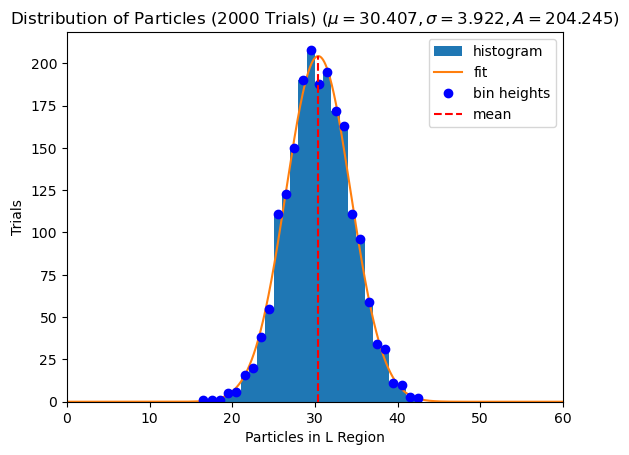

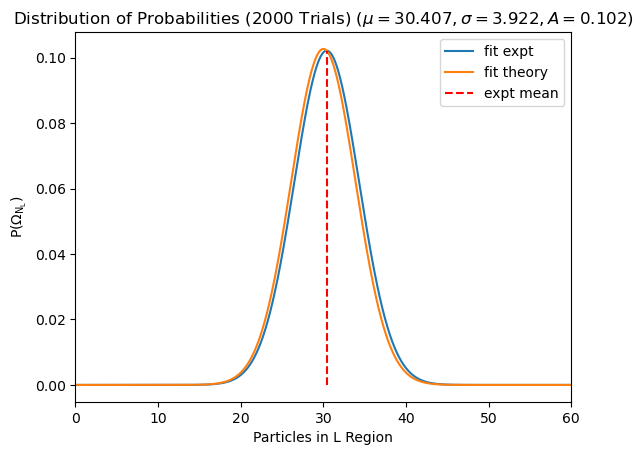

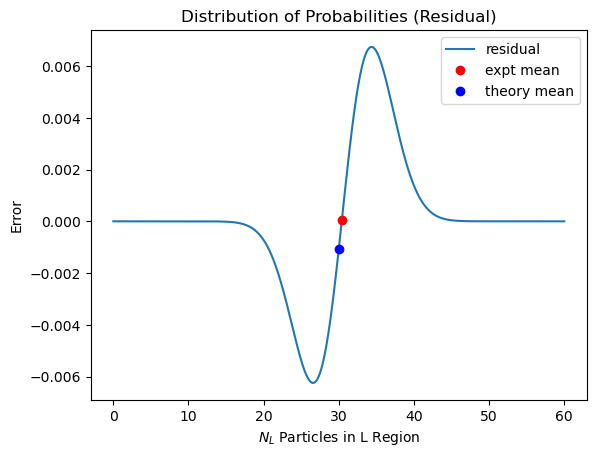

In [16]:
with open("data4.p", "rb") as f:
    sims2 = pickle.load(f)

# Curve fit a gaussian to a histogram
def gaussian(x, mean, standard_deviation, amplitude):
    return amplitude * np.exp(-(x-mean)**2 / (2*standard_deviation**2)) 


plt.figure()

# Histogram
data = np.array([b[0][0] for b in sims2])
bin_heights, bin_borders, _ = plt.hist(data, bins=(max(data)-min(data)), label="histogram")
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

# Curve Fit
popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[N_display/2, 1., 100]) # educated guess
# x_fit_expt = np.linspace(bin_borders[0], bin_borders[-1], 10000)
y_fit_expt = gaussian(x_fit, *popt)

plt.title("Distribution of Particles (2000 Trials) ($\mu={:.3f}, \sigma={:.3f}, A={:.3f}$)".format(popt[0], popt[1], popt[2]))
# plt.title("{} Trials vs # Particles Histogram ($\mu={:.3f}, \sigma={:.3f}, A={:.3f}$)".format(TRIALS, popt[0], popt[1], popt[2]))
plt.plot(x_fit, y_fit_expt, label="fit")
plt.plot(bin_centers, bin_heights, "bo", label="bin heights")
# print(bin_centers)
# print(bin_heights/1000)
plt.vlines(popt[0], 0, popt[2], linestyle="--", color="r", label="mean")
plt.xlim([0, N_display])
plt.xlabel("Particles in L Region")
plt.ylabel("Trials")
plt.legend()
plt.savefig("probability_histogram.png")
plt.show()

popt, _ = curve_fit(gaussian, bin_centers, bin_heights/2000, p0=[30, 1., 0.1]) # educated guess
x_fit_expt = np.linspace(0, N_display, 10000)
y_fit_expt = gaussian(x_fit, *popt)
f_expt = interp1d(x_fit_expt, y_fit_expt)
plt.figure()
plt.title("Distribution of Probabilities (2000 Trials) ($\mu={:.3f}, \sigma={:.3f}, A={:.3f}$)".format(popt[0], popt[1], popt[2]))
# plt.plot(bin_centers, bin_heights/TRIALS, "o", label="expt histogram")
plt.plot(x_fit, y_fit_expt, label="fit expt")
plt.plot(x_fit, y_fit_theory, label="fit theory")
plt.vlines(popt[0], 0, popt[2], linestyle="--", color="r", label="expt mean")
# plt.xlim([min(bin_centers), max(bin_centers)])
plt.xlabel("Particles in L Region")
plt.ylabel("$\mathrm{P}(\Omega_{\mathrm{N_L}})$")
plt.xlim([0, N_display])
plt.legend()
plt.savefig("probability_experiment.png")
plt.show()

# from scipy.interpolate import interp1d
plt.figure()
# plt.plot(x_fit_theory, y_fit_theory)
# plt.plot(x_fit_expt, y_fit_expt)
plt.title("Distribution of Probabilities (Residual)")
# plt.plot(x_fit, y_fit_theory)
# plt.plot(x_fit, y_fit_expt)
f_residual = interp1d(x_fit, y_fit_expt-y_fit_theory, kind="linear")
plt.plot(x_fit, y_fit_expt-y_fit_theory, label="residual")
# plt.vlines(popt[0], min(y_fit_expt-y_fit_theory), max(y_fit_expt-y_fit_theory), linestyle="--", color="r", label="expt mean")
plt.plot(popt[0], f_residual(popt[0]), "ro", label="expt mean")
plt.plot(30, f_residual(30), "bo", label="theory mean")
# plt.vlines(30, min(y_fit_expt-y_fit_theory), max(y_fit_expt-y_fit_theory), linestyle="--", color="b", label="theory mean")
plt.xlabel("$N_L$ Particles in L Region")
plt.ylabel("Error")
plt.legend()
plt.savefig("probability_residual.png")
plt.show()

In [12]:
k = 1.380649e-23 # boltzmann constant
def maxwell_boltzmann(v, A, B, T):
	f = A/(T**(3/2))*(v**2)*np.exp((B*(v**2))/T)
	return f

C:\Users\joebs\AppData\Local\Temp\ipykernel_22720\3320888371.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(maxwell_boltzmann, bin_centers, bin_heights) # educated guess


NameError: name 'curve_fits' is not defined

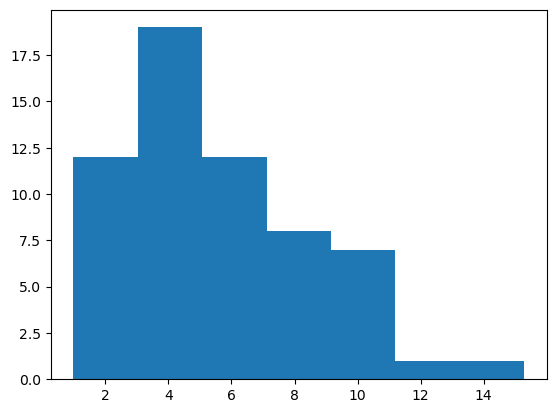

In [29]:
T = []
A = []
B = []

plt.figure()
for i in range(len(sims2)):
    data = sims2[i][1]
    bin_heights, bin_borders, _ = plt.hist(data, bins="auto")
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(maxwell_boltzmann, bin_centers, bin_heights) # educated guess
    x_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
    y_fit_expt = maxwell_boltzmann(x_fit, *popt)
    # curve_fits.append([x_fit, y_fit_expt])
    plt.plot(x_fit, y_fit_expt, label="fit: {}".format(i))
    plt.legend()
    
    A.append(popt[0])
    B.append(popt[1])
    T.append(popt[2])

T = np.array(T)
A = np.array(A)
B = np.array(B)

for x in (A, B, T):
    print("{} +/- {}".format(np.mean(x), np.std(x)/np.sqrt(10)))